In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow import keras
from scipy.stats import norm
from scipy.special import softmax
from sklearn.preprocessing import normalize

from vae import compute_mixture
from ans import code_rans, decode_rans
from bitsback import *

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

orig_x_train = x_train
orig_x_test = x_test

# Scale to be between [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(x_train.shape)

mnist_digits = x_train
mnist_digits = np.expand_dims(mnist_digits, -1)

(60000, 28, 28)


[-1.         -1.         -1.         -0.3647059   0.88235295  0.9843137
  0.9843137  -0.06666667 -0.8039216  -1.        ]


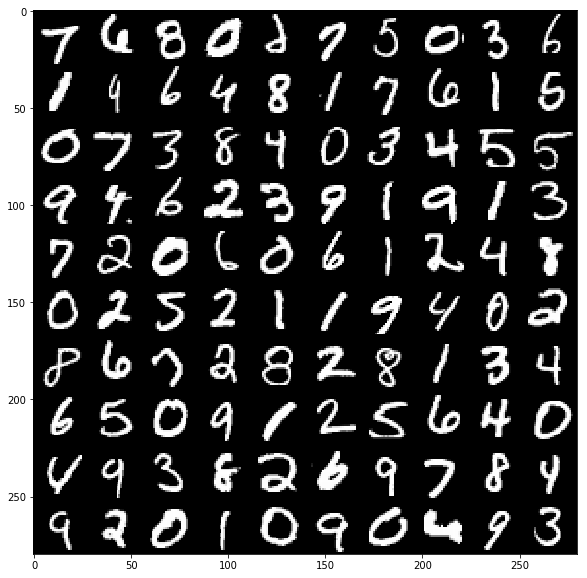

In [3]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(max(n, 3), max(n, 3)))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    

print(mnist_digits[0, 14, 10:20].reshape(10))
display_digits(mnist_digits)

In [4]:
enc = keras.models.load_model('vae-encoder')
dec = keras.models.load_model('vae-decoder')

In [5]:
print(x_test.shape)
q_dist = enc.predict(x_test)
q_mu, q_log_var = q_dist[0], q_dist[1]
print(q_mu.shape, q_log_var.shape)
q_mu[0], q_log_var[0]

(10000, 28, 28)
(10000, 50) (10000, 50)


(array([-0.00418074, -0.6863982 ,  0.23777205,  0.01182664,  0.16201535,
         0.7517904 , -0.8406163 ,  0.37193218, -0.02660786,  0.02477812,
         0.03521741, -0.1837031 ,  0.06102069, -0.05159136, -0.19667518,
         0.05182725, -0.16536298, -0.89891195, -0.9031797 ,  0.34662345,
        -0.1658136 , -0.10889547, -0.73488706, -0.08674301,  0.19672662,
        -0.19301084,  0.5712806 , -0.6918974 , -0.05548983, -0.43376273,
        -0.68052983,  0.5057588 ,  1.1284733 ,  0.4282058 , -0.40164697,
         0.70580786, -0.19304165, -0.20146622,  0.5090933 , -0.03365231,
        -0.2146689 ,  0.30100954,  1.1533277 , -0.5188112 ,  0.2542011 ,
         0.38329437, -0.505066  ,  0.1235477 ,  0.05496126, -0.16707547],
       dtype=float32),
 array([-5.903596 , -8.139683 , -6.538795 , -4.0511956, -4.025563 ,
        -7.8436975, -8.741323 , -8.013307 , -7.2704964, -7.7862444,
        -7.9346986, -6.215974 , -7.734417 , -7.799326 , -8.035149 ,
        -5.1388083, -7.7579255, -7.045126 

In [6]:
data = orig_x_test[:1].copy()
data = (data.astype('float32') - 127.5) / 127.5
q_dist = enc.predict(data)
q_mu, q_log_var = q_dist[0], q_dist[1]

stack = np.random.randint(low=0, high=(1 << 32) - 1, size=384, dtype=np.uint32).tolist()
stack.append(int(np.random.randint(low=(1 << 32), high=(1 << 63))))
init_stack = stack.copy()
stack, indexes = decode_y(stack, q_mu[0], q_log_var[0])
print(len(init_stack), len(stack))

385 376


In [7]:
stack = encode_y(indexes, stack, q_mu[0], q_log_var[0])
print(len(init_stack), len(stack))
print(stack[-5:], init_stack[-5:])
stack == init_stack

385 385
[286838259, 1589591058, 3175236879, 2221889575, 857163439657741339] [286838259, 1589591058, 3175236879, 2221889575, 857163439657741339]


True

In [8]:
def bitsback_append(data, stack, enc, dec):
    # Sample y from q(y|x_0) using the existing (ideally random) bits on the stack,
    # imaging that they were coded with a quantized q(y|x_0)
    # (This decreases coded message)
    q_dist = enc.predict((data.astype('float32') - 127.5) / 127.5)
    q_mu, q_log_var = q_dist[0], q_dist[1]
    stack, indexes = decode_y(stack, q_mu[0], q_log_var[0])
  
    # Translate quantized index to real value using bins
    quant_bits = 16
    bins = norm_bins(quant_bits=16)
    y = bins[indexes]
    dist = dec.predict(y.reshape(1, -1))    
    
    # Extract pixel distribution from decoder, flatten and quantize to frequencies
    n_components = 3
    m = dist[0, :, :, :n_components]
    invs = dist[0, :, :, n_components:2*n_components]
    logit_weights = dist[0, :, :, 2*n_components:3*n_components]
    weights = softmax(logit_weights[:, :, :], axis=-1)
    
    pvals = compute_mixture(m, invs, weights, n_components)
    pvals = pvals.reshape(-1, pvals.shape[-1])
    freqs = quantize_pval_distribution(pvals)
    
    # Encode data using ANS (increase coded message size)
    data = data.reshape(-1)
    stack = encode_x(data, freqs, stack)
    
    # Encode the sampled y values using isotropic normals
    stack = encode_y(indexes, stack)
    
    return stack
    
stack = np.random.randint(low=0, high=(1 << 32) - 1, size=256, dtype=np.uint32).tolist()
stack.append(int(np.random.randint(low=(1 << 32), high=(1 << 63))))
init_stack = stack.copy()
num_images = 100
for i in range(num_images):
    stack = bitsback_append(orig_x_test[i:(i+1)], stack, enc, dec)
    if i > 0 and i % 10 == 0:
        orig = 784 * i
        compress = 4*(len(stack) - len(init_stack)) + 4
        bits_per_dim = compress * 8 / orig
        print('[%s]: N=%05d, bits per dim=%.4f' % (datetime.now(), i, bits_per_dim))
        
print('[%s]: N=%05d, bits per dim=%.4f' % (datetime.now(), i, bits_per_dim))

[2021-01-04 19:09:54.477485]: N=00010, bits per dim=1.9510
[2021-01-04 19:09:57.929379]: N=00020, bits per dim=1.9041
[2021-01-04 19:10:01.389966]: N=00030, bits per dim=1.8599
[2021-01-04 19:10:04.771260]: N=00040, bits per dim=1.7949
[2021-01-04 19:10:08.193748]: N=00050, bits per dim=1.7690
[2021-01-04 19:10:11.699296]: N=00060, bits per dim=1.7762
[2021-01-04 19:10:15.241064]: N=00070, bits per dim=1.7971
[2021-01-04 19:10:18.802869]: N=00080, bits per dim=1.7908
[2021-01-04 19:10:22.426885]: N=00090, bits per dim=1.8000
[2021-01-04 19:10:25.662969]: N=00099, bits per dim=1.8000


In [9]:
def bitsback_pop(stack, q_mu, q_log_var, enc, dec):
    # Decode y according to isotropic norms
    # (This decreases coded message)
    stack, y = decode_y(stack, np.zeros(len(q_mu)), np.zeros(len(q_log_var)))
    quant_y = quantize_y(y)
    ydecode = dequantize_y(quant_y)

    # Extract pixel distribution from decoder, flatten and quantize to frequencies
    dist = dec.predict(ydecode.reshape(1,-1))
   
    n_components = 3
    m = dist[0, :, :, :n_components]
    invs = dist[0, :, :, n_components:2*n_components]
    logit_weights = dist[0, :, :, 2*n_components:3*n_components]
    weights = softmax(logit_weights[:, :, :], axis=-1)
    
    pvals = compute_mixture(m, invs, weights, n_components)
    pvals = pvals.reshape(-1, pvals.shape[-1])
    freqs = quantize_distribution(pvals)
    
    # Decode data using ANS (decrease coded message size)
    stack, data = decode_x(freqs, stack)
    
    # Encode data using ANS (decrease coded message size)
    stack = encode_y(quant_y, stack)
    
    return data, stack

images = []
for i in range(num_images):
    data, stack = bitsback_pop(stack, q_mu[i], q_log_var[i], enc, dec)
    images = [data] + images
print(len(stack))

NameError: name 'quantize_y' is not defined

In [ ]:
x1 = np.array(images[-1]).reshape(28, 28).tolist()
x2 = orig_x_test[num_images - 1].tolist()
x1 == x2, stack == init_stack

In [ ]:
stack[-10:], init_stack[-10:]